In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import scipy.stats as st
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.ion()

In [2]:
def setPrintAll():
    InteractiveShell.ast_node_interactivity = "all"
def setPrintLast():
    InteractiveShell.ast_node_interactivity = "last"
    
    
def displayImage(curImage):
    hist,_=calcHist(curImage)
    pdf=calcPdf(hist)
    cdf=calcCdf(pdf)
    
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(221)
    plt.imshow(curImage,cmap='gray')

    plt.subplot(222)
    plt.grid(True)
    plt.title('Histogram of Image')
    plt.xlabel('gray scale rank level')
    plt.ylabel('number of pixels')
    plt.bar(range(len(hist)), hist,width=0.8)

    plt.subplot(223)
    plt.grid(True)
    plt.title('PDF of Image')
    plt.xlabel('gray scale rank level')
    plt.ylabel('Probability density function')
    plt.plot(pdf)

    plt.subplot(224)
    plt.grid(True)
    plt.title('CDF of Image')
    plt.xlabel('gray scale rank level')
    plt.ylabel('Cumulative distribution function')
    plt.plot(cdf)

    plt.tight_layout()
    
def rgb2gray(rgb):
    if len(rgb.shape)<=2:
        return rgb
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def calcHist(raw): 
    hist=np.zeros(256)
    unique, counts = np.unique(raw.astype(int), return_counts=True)
    for i,rank in enumerate(unique):
        hist[int(rank)]=counts[i]
    return hist,unique[0]

def calcPdf(hist):
    return hist/np.sum(hist)

def calcCumHist(hist):
    return np.cumsum(hist,dtype=int)

def calcCdf(pdf):
    return np.cumsum(pdf,dtype=float)

In [3]:
img_cpt=misc.imread('./capitol.jpg')
img_sketch=rgb2gray(misc.imread('./sketch.jpg'))

### Q1. Image Smoothing

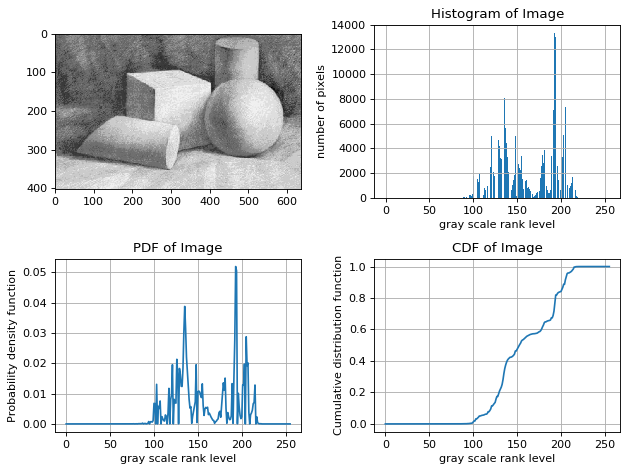

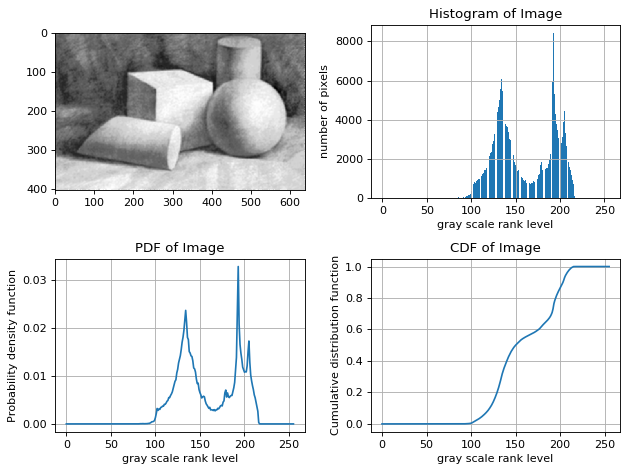

In [4]:
def gkern(kernlen=21, nsig=3):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def gaussian_smooth(img,k_size=11):
    h,w=img.shape
    kernel=gkern(kernlen=k_size)
    new_img=ndimage.filters.convolve(img,kernel)
    return new_img
    
def smooth(img,k_size=3):
    kernel=np.ones((k_size,k_size))/(k_size**2)
    h,w=img.shape
    new_img=np.copy(img)
    for k_i in range(h-k_size):
        for k_j in range(w-k_size):
            _=0
            for i in range(k_size):
                for j in range(k_size):
                    _+=img[k_i+i][k_j+j]*kernel[i][j]
            new_img[k_i+k_size//2][k_j+k_size//2]=_
    return new_img

displayImage(img_sketch)
displayImage(smooth(img_sketch,5))

### Q2. Edge Detecting

In [5]:
smoothed_sketch=smooth(img_sketch,5)

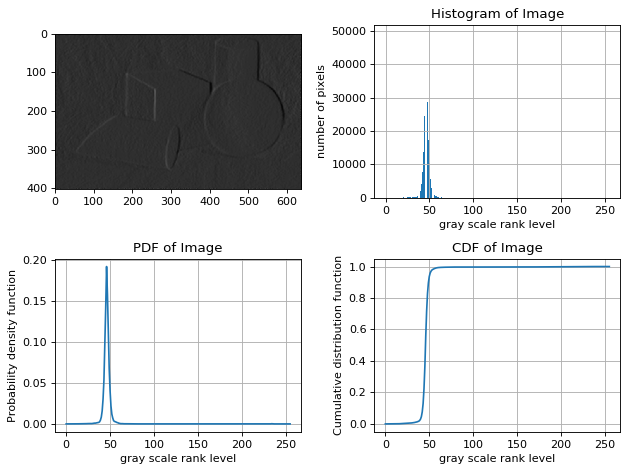

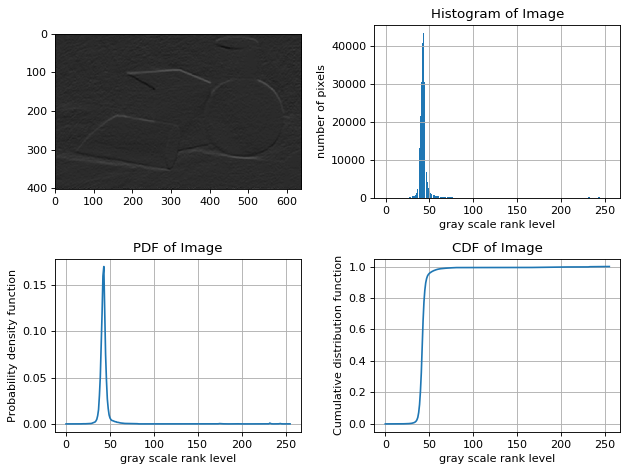

In [6]:
def normalize(img):
    return 255*(img-img.min())/(img.max()-img.min())
def derive_x(img):
    ker=[-1,0,1]
    h,w=img.shape
    new_img=np.copy(img)
    
    for i in range(h):
        for j in range(1,w-1):
            new_img[i][j]=sum(img[i][j-1:j+2]*ker)
#     new_img=255*(new_img-new_img.min())/(new_img.max()-new_img.min())
#     displayImage(new_img)
    return normalize(new_img)

def derive_y(img):
    ker=[-1,0,1]
    h,w=img.shape
    new_img=np.copy(img)
    for i in range(1,h-1):
        for j in range(1,w):
            new_img[i][j]=img[i+1][j]-img[i-1][j]
#     new_img=255*(new_img-new_img.min())/(new_img.max()-new_img.min())
#     displayImage(new_img)
    return normalize(new_img)

der_x=derive_x(smoothed_sketch)
der_y=derive_y(smoothed_sketch)
displayImage(der_x)
displayImage(der_y)

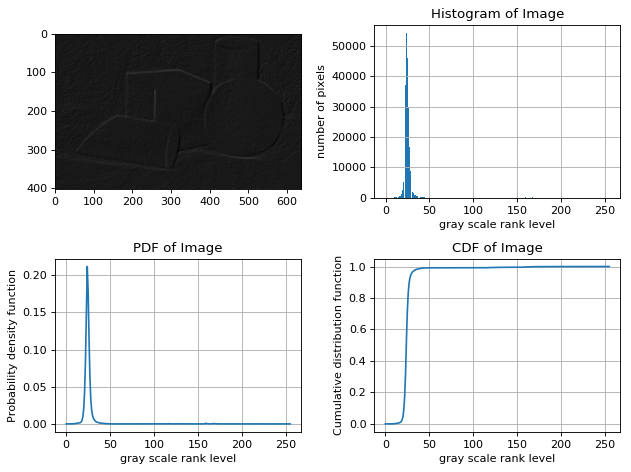

In [7]:
edge_sketch=normalize(np.sqrt(der_x**2+der_y**2))
displayImage(edge_sketch)

/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


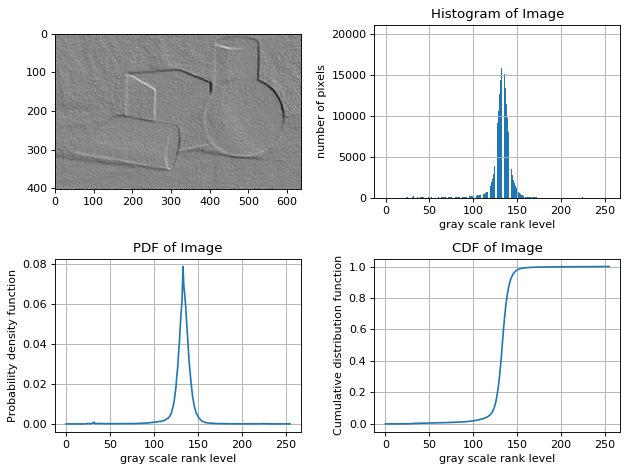

In [8]:
orient_sketch=normalize(np.arctan(der_x/der_y))
displayImage(orient_sketch)

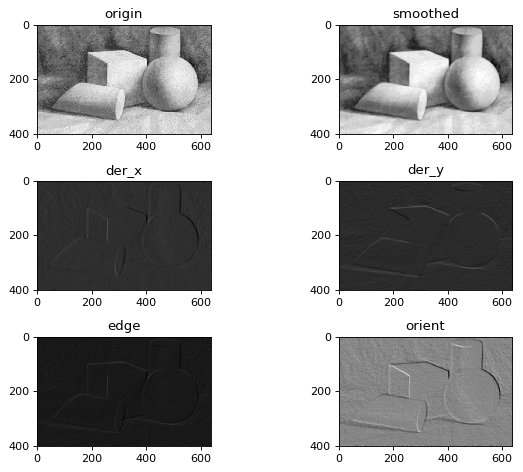

In [9]:
def displaySix(imgs):
    img1,img2,img3,img4,img5,img6=imgs
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(321)
    plt.imshow(img1,cmap='gray')
    plt.title('origin')

    plt.subplot(322)
    plt.imshow(img2,cmap='gray')
    plt.title('smoothed')

    plt.subplot(323)
    plt.imshow(img3,cmap='gray')
    plt.title('der_x')

    plt.subplot(324)
    plt.imshow(img4,cmap='gray')
    plt.title('der_y')
    
    plt.subplot(325)
    plt.imshow(img5,cmap='gray')
    plt.title('edge')
    
    plt.subplot(326)
    plt.imshow(img6,cmap='gray')
    plt.title('orient')
    
    plt.tight_layout()
displaySix([img_sketch,smoothed_sketch,der_x,der_y,edge_sketch,orient_sketch])

### Q3. Template Matching

(53, 49)

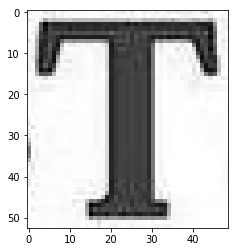

In [15]:
template=rgb2gray(misc.imread('./t.png'))
plt.imshow(template,cmap='gray')
template_mask=template-template.mean()
tm=template_mask
tm.shape

(294, 272)

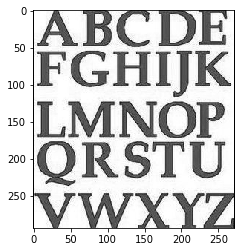

In [16]:
toMatch=rgb2gray(misc.imread('./alps.png'))
plt.imshow(toMatch,cmap='gray')
toMatch.shape

In [57]:
def conv(img,kernel):
    h,w=img.shape
    new_img=np.copy(img)
    h_k,w_k=kernel.shape
    for k_i in range(h-h_k):
        for k_j in range(w-w_k):
            _=0
            for i in range(h_k):
                for j in range(w_k):
                    _+=img[k_i+i][k_j+j]*kernel[i][j]
            new_img[k_i+h_k//2][k_j+w_k//2]=_
    return new_img

cor_res=conv(toMatch-toMatch.mean(),tm)

In [58]:
norm_cor_res=cor_res/(cor_res.max()-cor_res.min())

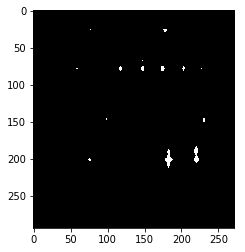

In [59]:
plt.imshow(rr>0.3,cmap='gray')

In [65]:
lpl=np.array([[0,-1,0], [-1,4,-1], [0,-1,0]])
crr=conv(smooth(cor_res,5),lpl)
crr=crr/(crr.max()-crr.min())

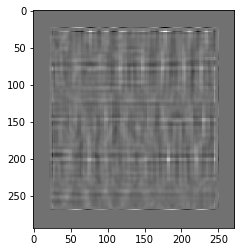

In [66]:
plt.imshow(crr,cmap='gray')

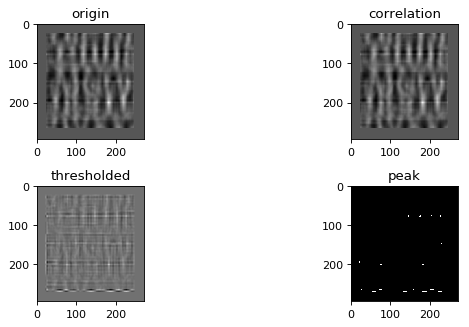

In [71]:
def displayFour(imgs):
    img1,img2,img3,img4=imgs
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(321)
    plt.imshow(img1,cmap='gray')
    plt.title('origin')

    plt.subplot(322)
    plt.imshow(img2,cmap='gray')
    plt.title('correlation')

    plt.subplot(323)
    plt.imshow(img3,cmap='gray')
    plt.title('thresholded')

    plt.subplot(324)
    plt.imshow(img4,cmap='gray')
    plt.title('peak')
    
    plt.tight_layout()
displayFour([res,rr,crr,crr>0.2])